## Import Libraries

In [11]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

## Normalize Data

In [12]:
def normalize_data(dataset, data_min, data_max):
    data_std = (dataset - data_min) / (data_max - data_min)
    test_scaled = data_std * (np.amax(data_std) - np.amin(data_std)) + np.amin(data_std)
    return test_scaled

## Import and Pre-Process Data

In [13]:
#import and pre-process data
def import_data(train_dataframe, dev_dataframe, test_dataframe):
    dataset = train_dataframe.values
    dataset = dataset.astype('float32')

    max_test = np.max(dataset[:, 12])
    min_test = np.min(dataset[:, 12])
    scale_factor = max_test - min_test
    max = np.empty(13)
    min = np.empty(13)

    for i in range(0, 13):
        min[i] = np.amin(dataset[:, i], axis=0)
        max[i] = np.amax(dataset[:, i], axis=0)
        dataset[:, i] = normalize_data(dataset[:, i], min[i], max[i])

    train_data = dataset[:, 0:12]
    train_labels = dataset[:, 12]

    dataset = dev_dataframe.values
    dataset = dataset.astype('float32')

    for i in range(0, 13):
        dataset[:, i] = normalize_data(dataset[:, i], min[i], max[i])

    dev_data = dataset[:, 0:12]
    dev_labels = dataset[:, 12]

    dataset = test_dataframe.values
    dataset = dataset.astype('float32')

    for i in range(0, 13):
        dataset[:, i] = normalize_data(dataset[:, i], min[i], max[i])

    test_data = dataset[:, 0:12]
    test_labels = dataset[:, 12]

    return train_data, train_labels, dev_data, dev_labels, test_data, test_labels, scale_factor


## Build LSTM Model

In [14]:
def build_model(init_type='glorot_uniform', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(64, input_shape=(None, 12), return_sequences=True, kernel_initializer=init_type))
    model.add(Dropout(0.2))
    model.add(LSTM(64, return_sequences=False, kernel_initializer=init_type))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='relu', kernel_initializer=init_type))

    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model


## Save CSV

In [15]:
def write_to_csv(prediction, filename):
    print("Writing to CSV...")
    with open(filename, 'w') as file:
        for i in range(prediction.shape[0]):
            file.write("%.5f" % prediction[i][0])
            file.write('\n')
    print("...finished!")

## Calculate MSE

In [16]:
def mse(predicted, observed):
    return np.mean(np.square(predicted - observed))

## Train Model and Show Output Results


Epoch 1: val_loss improved from inf to 0.05447, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 0.05447 to 0.04947, saving model to best_model.h5

Epoch 3: val_loss improved from 0.04947 to 0.04672, saving model to best_model.h5

Epoch 4: val_loss improved from 0.04672 to 0.04170, saving model to best_model.h5

Epoch 5: val_loss improved from 0.04170 to 0.03434, saving model to best_model.h5

Epoch 6: val_loss improved from 0.03434 to 0.02892, saving model to best_model.h5

Epoch 7: val_loss improved from 0.02892 to 0.02837, saving model to best_model.h5

Epoch 8: val_loss improved from 0.02837 to 0.02745, saving model to best_model.h5

Epoch 9: val_loss improved from 0.02745 to 0.02488, saving model to best_model.h5

Epoch 10: val_loss improved from 0.02488 to 0.02373, saving model to best_model.h5

Epoch 11: val_loss did not improve from 0.02373

Epoch 12: val_loss improved from 0.02373 to 0.02252, saving model to best_model.h5

Epoch 13: val_loss did not improve from 0.02252

Epoch 14: val_loss did not improve from 0.02252

Epoch 15: val_loss d

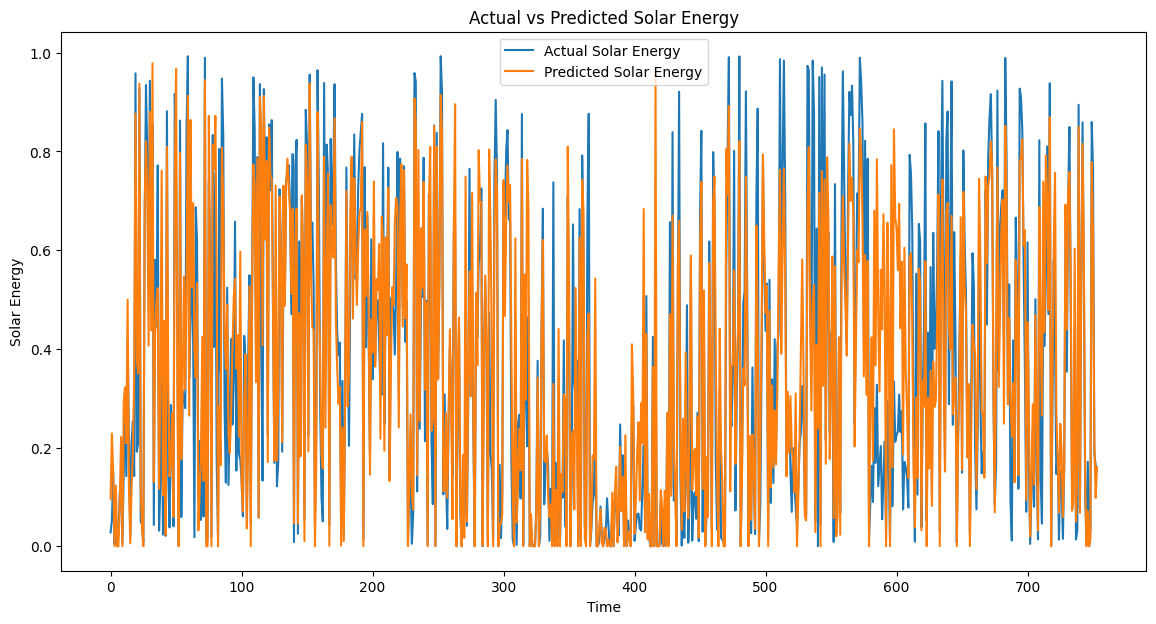

In [20]:
def main():
    # Define headers
    headers = ['hour', 'day', 'month', 'year', 'cloud-coverage', 'Visibility', 'temperature', 'dew-point', 'relative-humidity', 'wind-speed', 'station-pressure', 'altimeter', 'solar-energy']

    # Load and preprocess data
    train_dataframe = pd.read_csv('weather_train.csv', sep=";", engine='python', header=None, names=headers)
    dev_dataframe = pd.read_csv('weather_dev.csv', sep=";", engine='python', header=None, names=headers)
    test_dataframe = pd.read_csv('weather_test.csv', sep=";", engine='python', header=None, names=headers)

    # Sort data in ascending order by date-related columns
    train_dataframe.sort_values(by=['year', 'month', 'day', 'hour'], inplace=True)
    dev_dataframe.sort_values(by=['year', 'month', 'day', 'hour'], inplace=True)
    test_dataframe.sort_values(by=['year', 'month', 'day', 'hour'], inplace=True)

    train_data, train_labels, dev_data, dev_labels, test_data, test_labels, scale_factor = import_data(train_dataframe, dev_dataframe, test_dataframe)

    # Reshape data for LSTM
    X_train = np.reshape(train_data, (train_data.shape[0], 1, train_data.shape[1]))
    X_dev = np.reshape(dev_data, (dev_data.shape[0], 1, dev_data.shape[1]))
    X_test = np.reshape(test_data, (test_data.shape[0], 1, test_data.shape[1]))
    Y_train = np.reshape(train_labels, (train_labels.shape[0], 1))
    Y_dev = np.reshape(dev_labels, (dev_labels.shape[0], 1))
    Y_test = np.reshape(test_labels, (test_labels.shape[0], 1))

    # Build model
    model = build_model('glorot_uniform', 'adam')

    # Add ModelCheckpoint callback
    callbacks = [
        ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
    ]

    # Train model
    model_fit_epochs = 150
    model.fit(X_train, Y_train, batch_size=16, epochs=model_fit_epochs, validation_data=(X_dev, Y_dev), callbacks=callbacks, verbose=0)

    # Load the best model
    model.load_weights('best_model.h5')

    # Predict and evaluate
    trainset_predicted = model.predict(X_train, verbose=0)
    devset_predicted = model.predict(X_dev, verbose=0)
    testset_predicted = model.predict(X_test, verbose=0)

    print("Train MSE: ", mse(trainset_predicted, Y_train) * scale_factor * scale_factor)
    print("Dev MSE: ", mse(devset_predicted, Y_dev) * scale_factor * scale_factor)
    print("Test MSE: ", mse(testset_predicted, Y_test) * scale_factor * scale_factor)

    # Grid search to optimize model params
    init = ['glorot_uniform', 'normal', 'uniform']
    epochs = [50, 100, 150]
    batches = [8, 16, 32]
    optimizers = ['rmsprop', 'adam']
    optimal_params = np.empty(4)
    minimum_error = float('inf')

    for init_type in init:
        for epoch in epochs:
            for batch in batches:
                for optimizer in optimizers:
                    model = build_model(init_type, optimizer)
                    model.fit(X_train, Y_train, batch_size=batch, epochs=epoch, validation_data=(X_dev, Y_dev), verbose=0)
                    predicted = model.predict(X_dev, verbose=0)
                    error = mse(predicted, Y_dev)
                    if error < minimum_error:
                        minimum_error = error
                        optimal_params = [init_type, epoch, batch, optimizer]

    print("Optimal params: ", optimal_params)
    print("Minimized error: ", minimum_error)

    write_to_csv(trainset_predicted, 'nn_trainset_prediction.csv')
    write_to_csv(devset_predicted, 'nn_devset_prediction.csv')
    write_to_csv(testset_predicted, 'nn_testset_prediction.csv')

    # Visualization
    plt.figure(figsize=(14, 7))
    plt.plot(Y_test, label='Actual Solar Energy')
    plt.plot(testset_predicted, label='Predicted Solar Energy')
    plt.title('Actual vs Predicted Solar Energy')
    plt.xlabel('Time')
    plt.ylabel('Solar Energy')
    plt.legend()
    plt.show()

if __name__ == '__main__':
    main()
